# 推荐系统质量抽检

本 notebook 用于快速抽样检验两种推荐策略的输出质量：

1. **Multi-Dimensional Recommender** - 多维度召回+精排，用于最终展示
2. **Simple Recall Recommender** - 5规则粗排召回，供 LLM 精排使用

每个策略独立分析，可以快速抽样看推荐结果是否合理。

In [1]:
# Setup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'Heiti TC', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# 数据路径
BASE_DIR = Path("..")
SAMPLE_DIR = BASE_DIR / "output" / "output_production_sample"

# 加载数据
with open(SAMPLE_DIR / "recommender" / "recommendations.json", "r", encoding="utf-8") as f:
    multidim_data = json.load(f)
with open(SAMPLE_DIR / "simple_recall" / "recall_results.json", "r", encoding="utf-8") as f:
    simple_data = json.load(f)
with open(SAMPLE_DIR / "company_tagging" / "company_tags.json", "r", encoding="utf-8") as f:
    tags_dict = {t['company_id']: t for t in json.load(f)}

companies_df = pd.read_csv(BASE_DIR / "data" / "aihirebox_company_list_sample.csv")
company_info = companies_df.set_index('company_id').to_dict('index')

print("✅ 数据加载完成")
print(f"   Multi-Dim: {len(multidim_data)} 家公司的推荐")
print(f"   Simple Recall: {len(simple_data)} 家公司的召回")

✅ 数据加载完成
   Multi-Dim: 32 家公司的推荐
   Simple Recall: 32 家公司的召回


---
# Part 1: Multi-Dimensional Recommender 分析

这是**精排后的最终推荐**，特点：
- 多维度推荐（行业、商业模式、技术方向等）
- 有分数阈值过滤（≥0.6）
- 有多样性约束（同一公司只出现在一个维度）
- 复合头部抑制（Stage 60% + IDF 40%）

In [2]:
# 展平 Multi-Dim 数据
multidim_records = []
for rec in multidim_data:
    for group in rec["recommendation_groups"]:
        for c in group["companies"]:
            multidim_records.append({
                "query_id": rec["query_company_id"],
                "query_name": rec["query_company_name"],
                "dimension": group["dimension_label_en"],  # 用英文避免字体问题
                "dimension_zh": group["dimension_label_zh"],  # 保留中文供 print
                "rec_id": c["company_id"],
                "rec_name": c["company_name"],
                "score": c["similarity_score"],
                "raw_score": c["raw_score"],
                "emb_score": c.get("embedding_score", 0),
                "head_penalty": c["head_penalty_applied"],
            })
df_md = pd.DataFrame(multidim_records)

print("="*60)
print("📊 Multi-Dim Recommender 数据概览")
print("="*60)
print(f"\n总推荐条数: {len(df_md)}")
print(f"查询公司数: {df_md['query_id'].nunique()}")
print(f"被推荐公司数: {df_md['rec_id'].nunique()}")
print(f"平均每家公司推荐数: {len(df_md) / df_md['query_id'].nunique():.1f}")
print(f"\n使用的维度: {df_md['dimension'].nunique()} 个")
print(f"头部抑制应用率: {df_md['head_penalty'].mean()*100:.1f}%")

📊 Multi-Dim Recommender 数据概览

总推荐条数: 408
查询公司数: 32
被推荐公司数: 19
平均每家公司推荐数: 12.8

使用的维度: 7 个
头部抑制应用率: 100.0%


📊 Multi-Dim 分数分布

【final_score 最终分数】
  含义: 经过头部抑制后的最终分数，用于排序
  公式: 0.6 × tag_score + 0.4 × emb_score - head_penalty
  范围: 0.608 ~ 0.862
  均值: 0.752
  中位数: 0.794


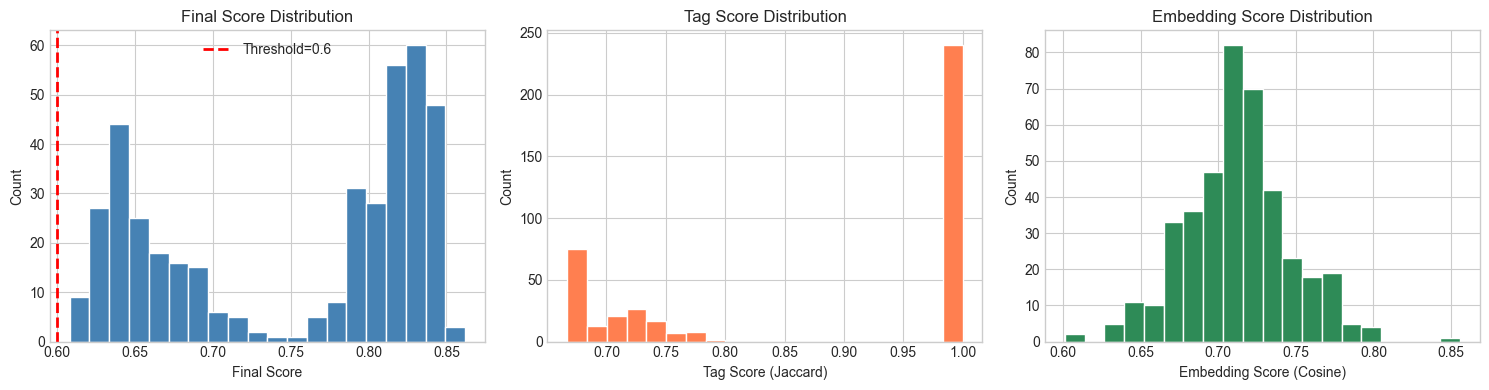


💡 解读:
  • 最终分数都 ≥0.6，因为有分数阈值过滤
  • Tag 分数 = 标签交集/标签并集（Jaccard），越高表示标签越相似
  • Embedding 分数 = 描述文本的语义相似度，越高表示业务越相似


In [3]:
# Multi-Dim 分数分布
print("="*60)
print("📊 Multi-Dim 分数分布")
print("="*60)
print("\n【final_score 最终分数】")
print("  含义: 经过头部抑制后的最终分数，用于排序")
print("  公式: 0.6 × tag_score + 0.4 × emb_score - head_penalty")
print(f"  范围: {df_md['score'].min():.3f} ~ {df_md['score'].max():.3f}")
print(f"  均值: {df_md['score'].mean():.3f}")
print(f"  中位数: {df_md['score'].median():.3f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 最终分数
ax = axes[0]
counts, bins, _ = ax.hist(df_md['score'], bins=20, color='steelblue', edgecolor='white')
ax.axvline(0.6, color='red', linestyle='--', linewidth=2, label='Threshold=0.6')
ax.set_xlabel('Final Score')
ax.set_ylabel('Count')
ax.set_title('Final Score Distribution')
ax.legend()

# Tag 分数
ax = axes[1]
ax.hist(df_md['raw_score'], bins=20, color='coral', edgecolor='white')
ax.set_xlabel('Tag Score (Jaccard)')
ax.set_ylabel('Count')
ax.set_title('Tag Score Distribution')

# Embedding 分数
ax = axes[2]
ax.hist(df_md['emb_score'], bins=20, color='seagreen', edgecolor='white')
ax.set_xlabel('Embedding Score (Cosine)')
ax.set_ylabel('Count')
ax.set_title('Embedding Score Distribution')

plt.tight_layout()
plt.show()

print("\n💡 解读:")
print("  • 最终分数都 ≥0.6，因为有分数阈值过滤")
print("  • Tag 分数 = 标签交集/标签并集（Jaccard），越高表示标签越相似")
print("  • Embedding 分数 = 描述文本的语义相似度，越高表示业务越相似")

📊 Multi-Dim 各维度使用频率

【dimension 推荐维度】
  含义: 推荐的切入角度，如'同为AI大模型公司'、'同为B2B企业服务'等


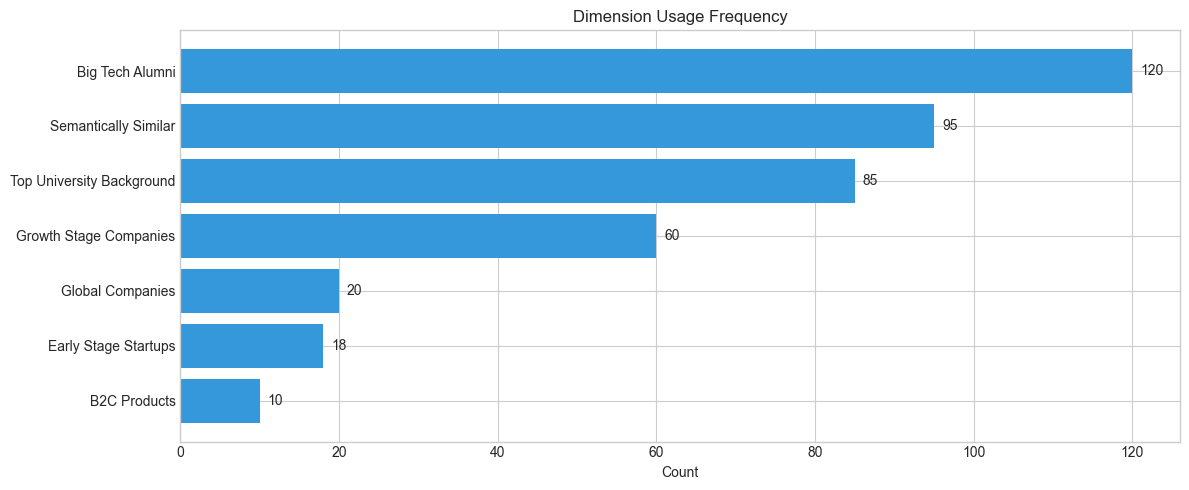


💡 解读:
  • 使用最多的维度说明这些特征在公司间最常见
  • 如果某些维度很少出现，可能是标签分布不均或阈值过高


In [4]:
# Multi-Dim 维度使用分布
print("="*60)
print("📊 Multi-Dim 各维度使用频率")
print("="*60)
print("\n【dimension 推荐维度】")
print("  含义: 推荐的切入角度，如'同为AI大模型公司'、'同为B2B企业服务'等")

dim_counts = df_md['dimension'].value_counts()

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.barh(range(len(dim_counts)), dim_counts.values, color='#3498db')
ax.set_yticks(range(len(dim_counts)))
ax.set_yticklabels(dim_counts.index)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title('Dimension Usage Frequency')

for bar, val in zip(bars, dim_counts.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, str(val), va='center')

plt.tight_layout()
plt.show()

print("\n💡 解读:")
print("  • 使用最多的维度说明这些特征在公司间最常见")
print("  • 如果某些维度很少出现，可能是标签分布不均或阈值过高")

📊 Multi-Dim 公司被推荐次数分布

【times_recommended 被推荐次数】
  含义: 某公司出现在其他公司推荐列表中的次数
  期望: 分布均匀，不要少数公司霸榜


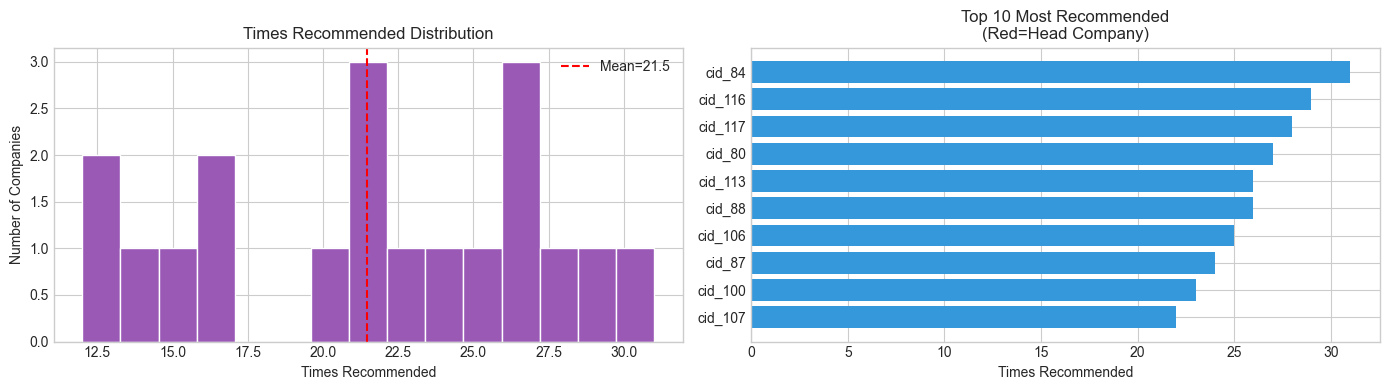


📋 Top 10 公司名称对照:
   cid_84: 最右 (31次) 🔵
   cid_116: 荣耀 (29次) 🔵
   cid_117: 零一万物 (28次) 🔵
   cid_80: JOJOMath（成都书声科技有限公司） (27次) 🔵
   cid_113: 百川智能 (26次) 🔵
   cid_88: 蚂蚁数字科技 (26次) 🔵
   cid_106: 阶跃星辰 (25次) 🔵
   cid_87: 智元机器人 (24次) 🔵
   cid_100: MiniMax (23次) 🔵
   cid_107: 字节 火山引擎 (22次) 🔵

📈 统计:
  • 被推荐最多: 31 次
  • 被推荐最少: 12 次
  • 平均被推荐: 21.5 次


In [5]:
# Multi-Dim 被推荐次数分布
print("="*60)
print("📊 Multi-Dim 公司被推荐次数分布")
print("="*60)
print("\n【times_recommended 被推荐次数】")
print("  含义: 某公司出现在其他公司推荐列表中的次数")
print("  期望: 分布均匀，不要少数公司霸榜")

rec_counts = df_md['rec_id'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 分布直方图
ax = axes[0]
ax.hist(rec_counts.values, bins=15, color='#9b59b6', edgecolor='white')
ax.axvline(rec_counts.mean(), color='red', linestyle='--', label=f'Mean={rec_counts.mean():.1f}')
ax.set_xlabel('Times Recommended')
ax.set_ylabel('Number of Companies')
ax.set_title('Times Recommended Distribution')
ax.legend()

# Top 10 柱状图（用 company_id 作为标签避免中文字体问题）
ax = axes[1]
top10 = rec_counts.head(10)
top10_labels = list(top10.index)  # 用 company_id
colors = ['#e74c3c' if tags_dict.get(cid, {}).get('company_stage') in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else '#3498db' for cid in top10.index]
ax.barh(range(len(top10)), top10.values, color=colors)
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10_labels)
ax.invert_yaxis()
ax.set_xlabel('Times Recommended')
ax.set_title('Top 10 Most Recommended\n(Red=Head Company)')

plt.tight_layout()
plt.show()

# 打印公司名称对照表
print("\n📋 Top 10 公司名称对照:")
for cid, count in top10.items():
    name = company_info.get(cid, {}).get('company_name', cid)
    stage = tags_dict.get(cid, {}).get('company_stage', 'unknown')
    head_mark = '🔴头部' if stage in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else '🔵'
    print(f"   {cid}: {name} ({count}次) {head_mark}")

print(f"\n📈 统计:")
print(f"  • 被推荐最多: {rec_counts.max()} 次")
print(f"  • 被推荐最少: {rec_counts.min()} 次")
print(f"  • 平均被推荐: {rec_counts.mean():.1f} 次")

In [6]:
# Multi-Dim 抽样检验函数
def inspect_multidim(company_id=None):
    """抽样查看 Multi-Dim 推荐结果，传入 company_id 或不传随机抽"""
    if company_id is None:
        rec = random.choice(multidim_data)
    else:
        rec = next((r for r in multidim_data if r['query_company_id'] == company_id), None)
        if not rec:
            print(f"❌ 找不到 {company_id}")
            return
    
    info = company_info.get(rec['query_company_id'], {})
    tags = tags_dict.get(rec['query_company_id'], {})
    
    print("\n" + "="*70)
    print(f"🔍 【{rec['query_company_name']}】的推荐结果")
    print("="*70)
    
    # 公司简介
    desc = info.get('company_details', '')[:150]
    print(f"\n📝 简介: {desc}...")
    
    # 标签
    print(f"\n🏷️ 标签:")
    print(f"   行业: {', '.join(tags.get('industry', []))}")
    print(f"   阶段: {tags.get('company_stage', 'unknown')}")
    print(f"   技术: {', '.join(tags.get('tech_focus', []))}")
    
    # 推荐结果
    print(f"\n📋 推荐结果 ({len(rec['recommendation_groups'])} 个维度):")
    for i, g in enumerate(rec['recommendation_groups'], 1):
        print(f"\n   【维度{i}】{g['dimension_label_zh']}")
        print(f"   共同标签: {', '.join(g['shared_tags'])}")
        for c in g['companies']:
            penalty = " ⬇头部抑制" if c['head_penalty_applied'] else ""
            emb = f", emb={c.get('embedding_score', 0):.2f}" if c.get('embedding_score') else ""
            print(f"      • {c['company_name'][:20]:<20} score={c['similarity_score']:.2f}{emb}{penalty}")
    
    print("\n" + "-"*70)
    print("💡 请思考: 这些推荐合理吗？被推荐公司和查询公司是否真的相似？")
    print("-"*70)

In [7]:
# 随机抽一个看看
inspect_multidim()


🔍 【蚂蚁集团】的推荐结果

📝 简介: 蚂蚁集团起步于2004年诞生的支付宝，源于一份为社会解决信任问题的初心，经过多年的发展，已成为世界领先的互联网开放平台。蚂蚁集团通过科技创新，助力合作伙伴，为消费者和小微企业提供普惠便捷的数字生活及数字金融服务；持续开放产品与技术，助力企业的数字化升级与协作；在全球广泛合作，服务当地商家和消费者实现...

🏷️ 标签:
   行业: fintech, cloud_infra, other
   阶段: public
   技术: data_infra, aigc

📋 推荐结果 (3 个维度):

   【维度1】同为大厂背景团队
   共同标签: serial_entrepreneur, top_university, bigtech_alumni
      • 最右                   score=0.85, emb=0.75 ⬇头部抑制
      • 智元机器人                score=0.83, emb=0.76 ⬇头部抑制
      • 零一万物                 score=0.82, emb=0.75 ⬇头部抑制
      • 小红书                  score=0.82, emb=0.72 ⬇头部抑制
      • 百川智能                 score=0.81, emb=0.71 ⬇头部抑制

   【维度2】同为顶尖高校背景
   共同标签: serial_entrepreneur, top_university, bigtech_alumni
      • DeepSeek             score=0.79, emb=0.71 ⬇头部抑制
      • 小冰跃动                 score=0.79, emb=0.74 ⬇头部抑制
      • 蚂蚁数字科技               score=0.69, emb=0.86 ⬇头部抑制
      • 荣耀                   score=0.66, emb=0.73 ⬇头部抑制
      • 阶跃星辰                 score=0.65, emb=0.72 ⬇头部抑制

   【维度3

In [8]:
# 再随机抽一个
inspect_multidim()


🔍 【月之暗面】的推荐结果

📝 简介: 北京月之暗面科技有限公司（Moonshot AI）是一家专注于通用人工智能研究和应用的高科技企业。公司主要业务领域包括人工智能算法研究、自然语言处理、计算机视觉、分布式机器学习系统、大数据分析等。其目标是以大规模语言模型为技术基础，开发通用人工智能系统，以准确、高性能、可规模化的方式为用户提供智能化...

🏷️ 标签:
   行业: ai_llm, healthtech, enterprise_saas
   阶段: early
   技术: llm_foundation, speech_nlp, computer_vision, data_infra

📋 推荐结果 (3 个维度):

   【维度1】同为全球化公司
   共同标签: china_domestic, global
      • 阶跃星辰                 score=0.84, emb=0.73 ⬇头部抑制
      • 字节 火山引擎              score=0.83, emb=0.71 ⬇头部抑制
      • 蚂蚁数字科技               score=0.82, emb=0.72 ⬇头部抑制
      • 百川智能                 score=0.81, emb=0.71 ⬇头部抑制
      • 智元机器人                score=0.81, emb=0.71 ⬇头部抑制

   【维度2】同为早期创业公司
   共同标签: early
      • YouWare (新言意码)       score=0.81, emb=0.66 ⬇头部抑制
      • DeepSeek             score=0.81, emb=0.77 ⬇头部抑制
      • 零一万物                 score=0.81, emb=0.72 ⬇头部抑制

   【维度3】业务描述相似
   共同标签: semantic
      • MiniMax              score=0.68, emb=0.74 ⬇头部抑制
      • 荣耀                   score=0.68, emb=0.72 ⬇头部抑制
    

In [9]:
# 指定某个公司看（改 company_id 即可）
# inspect_multidim('cid_100')  # MiniMax

---
# Part 2: Simple Recall Recommender 分析

这是**粗排召回**，特点：
- 5个规则召回（行业、技术、行业+市场、团队、行业+团队）
- 每规则 Top 20，无分数阈值过滤
- 无多样性约束（同一公司可出现在多个规则）
- 轻量头部抑制（仅 Stage，penalty=0.5）
- 用于后续 LLM 精排

In [10]:
# 展平 Simple Recall 数据
simple_records = []
for rec in simple_data:
    for group in rec["recall_groups"]:
        for c in group["candidates"]:
            simple_records.append({
                "query_id": rec["query_company"]["company_id"],
                "query_name": rec["query_company"]["company_name"],
                "rule": group["rule_name_en"],  # 用英文避免字体问题
                "rule_zh": group["rule_name"],  # 保留中文供 print
                "rec_id": c["company_id"],
                "rec_name": c["company_name"],
                "score": c["final_score"],
                "tag_score": c["tag_score"],
                "emb_score": c.get("embedding_score", 0),
                "head_penalty": c["head_penalty_applied"],
            })
df_sr = pd.DataFrame(simple_records)

print("="*60)
print("📊 Simple Recall 数据概览")
print("="*60)
print(f"\n总召回条数: {len(df_sr)}")
print(f"查询公司数: {df_sr['query_id'].nunique()}")
print(f"被召回公司数: {df_sr['rec_id'].nunique()}")
print(f"平均每家公司召回数: {len(df_sr) / df_sr['query_id'].nunique():.1f}")
print(f"\n使用的规则: {df_sr['rule'].nunique()} 个")
print(f"头部抑制应用率: {df_sr['head_penalty'].mean()*100:.1f}%")

📊 Simple Recall 数据概览

总召回条数: 2637
查询公司数: 32
被召回公司数: 32
平均每家公司召回数: 82.4

使用的规则: 5 个
头部抑制应用率: 30.9%


📊 Simple Recall 分数分布

【final_score 最终分数】
  含义: 0.6×tag_score + 0.4×emb_score，头部公司额外×0.5
  注意: 无分数阈值，所以会有低分候选
  范围: 0.183 ~ 0.942
  均值: 0.502


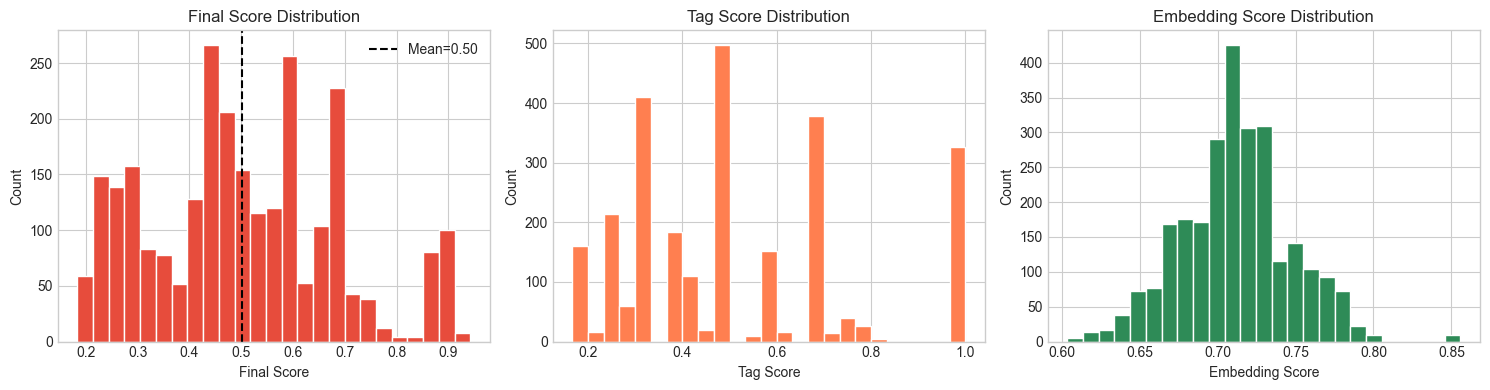


💡 解读:
  • 粗排无阈值过滤，所以分数范围更广
  • 低分候选会在后续 LLM 精排中被筛掉
  • 分数<0.4 的候选有 729 条 (27.6%)


In [11]:
# Simple Recall 分数分布
print("="*60)
print("📊 Simple Recall 分数分布")
print("="*60)
print("\n【final_score 最终分数】")
print("  含义: 0.6×tag_score + 0.4×emb_score，头部公司额外×0.5")
print("  注意: 无分数阈值，所以会有低分候选")
print(f"  范围: {df_sr['score'].min():.3f} ~ {df_sr['score'].max():.3f}")
print(f"  均值: {df_sr['score'].mean():.3f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.hist(df_sr['score'], bins=25, color='#e74c3c', edgecolor='white')
ax.axvline(df_sr['score'].mean(), color='black', linestyle='--', label=f'Mean={df_sr["score"].mean():.2f}')
ax.set_xlabel('Final Score')
ax.set_ylabel('Count')
ax.set_title('Final Score Distribution')
ax.legend()

ax = axes[1]
ax.hist(df_sr['tag_score'], bins=25, color='coral', edgecolor='white')
ax.set_xlabel('Tag Score')
ax.set_ylabel('Count')
ax.set_title('Tag Score Distribution')

ax = axes[2]
ax.hist(df_sr['emb_score'], bins=25, color='seagreen', edgecolor='white')
ax.set_xlabel('Embedding Score')
ax.set_ylabel('Count')
ax.set_title('Embedding Score Distribution')

plt.tight_layout()
plt.show()

print("\n💡 解读:")
print("  • 粗排无阈值过滤，所以分数范围更广")
print("  • 低分候选会在后续 LLM 精排中被筛掉")
print(f"  • 分数<0.4 的候选有 {(df_sr['score']<0.4).sum()} 条 ({(df_sr['score']<0.4).mean()*100:.1f}%)")

📊 Simple Recall 各规则使用频率

【5个召回规则】
  R1_industry: 同行业公司
  R2_tech_focus: 同技术方向
  R3_industry_market: 同行业+同市场
  R4_team_background: 同团队背景
  R5_industry_team: 同行业+同背景


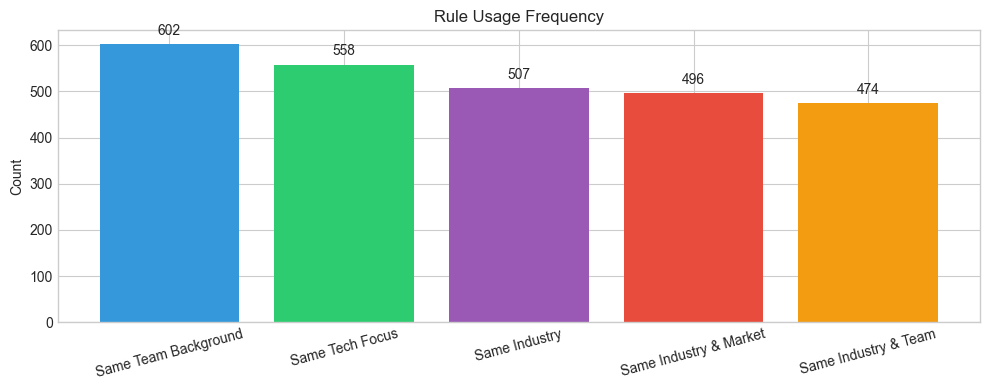


💡 解读:
  • 每个规则理论上最多召回 20×公司数 条
  • 如果某规则召回少，说明符合条件的公司少


In [12]:
# Simple Recall 规则使用分布
print("="*60)
print("📊 Simple Recall 各规则使用频率")
print("="*60)
print("\n【5个召回规则】")
print("  R1_industry: 同行业公司")
print("  R2_tech_focus: 同技术方向")
print("  R3_industry_market: 同行业+同市场")
print("  R4_team_background: 同团队背景")
print("  R5_industry_team: 同行业+同背景")

rule_counts = df_sr['rule'].value_counts()

fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#f39c12']
bars = ax.bar(range(len(rule_counts)), rule_counts.values, color=colors[:len(rule_counts)])
ax.set_xticks(range(len(rule_counts)))
ax.set_xticklabels(rule_counts.index, rotation=15)
ax.set_ylabel('Count')
ax.set_title('Rule Usage Frequency')

for bar, val in zip(bars, rule_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, str(val), ha='center')

plt.tight_layout()
plt.show()

print("\n💡 解读:")
print("  • 每个规则理论上最多召回 20×公司数 条")
print("  • 如果某规则召回少，说明符合条件的公司少")

📊 Simple Recall 公司被召回次数分布

【times_recalled 被召回次数】
  含义: 某公司在所有规则中被召回的总次数
  注意: 无多样性约束，同一公司可在多个规则中出现


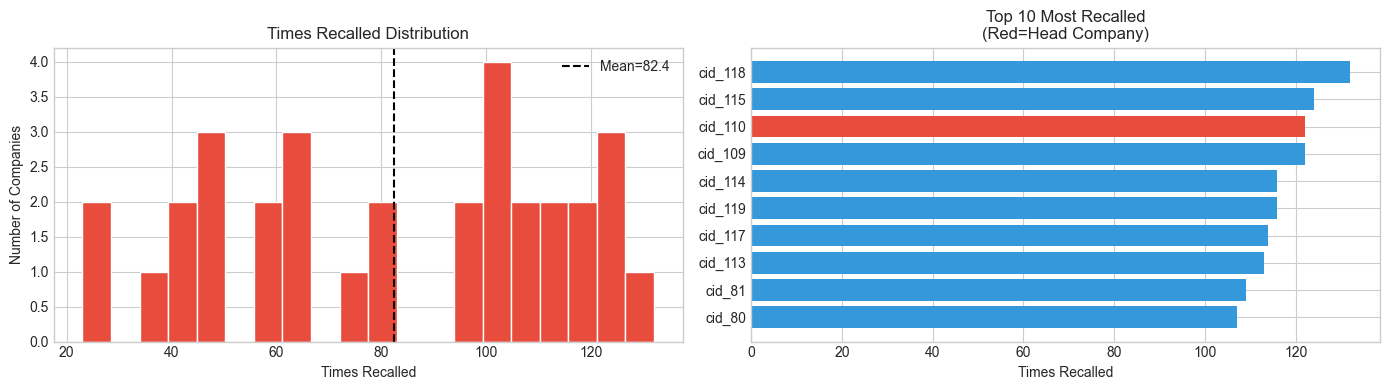


📋 Top 10 公司名称对照:
   cid_118: 小冰跃动 (132次) 🔵
   cid_115: 昆仑天工 (124次) 🔵
   cid_110: 百度智能云 (122次) 🔴头部
   cid_109: DeepSeek (122次) 🔵
   cid_114: 月之暗面 (116次) 🔵
   cid_119: 阿里国际 (116次) 🔵
   cid_117: 零一万物 (114次) 🔵
   cid_113: 百川智能 (113次) 🔵
   cid_81: YouWare (新言意码) (109次) 🔵
   cid_80: JOJOMath（成都书声科技有限公司） (107次) 🔵

📈 统计:
  • 被召回最多: 132 次
  • 平均被召回: 82.4 次


In [13]:
# Simple Recall 被召回次数分布
print("="*60)
print("📊 Simple Recall 公司被召回次数分布")
print("="*60)
print("\n【times_recalled 被召回次数】")
print("  含义: 某公司在所有规则中被召回的总次数")
print("  注意: 无多样性约束，同一公司可在多个规则中出现")

rec_counts_sr = df_sr['rec_id'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
ax.hist(rec_counts_sr.values, bins=20, color='#e74c3c', edgecolor='white')
ax.axvline(rec_counts_sr.mean(), color='black', linestyle='--', label=f'Mean={rec_counts_sr.mean():.1f}')
ax.set_xlabel('Times Recalled')
ax.set_ylabel('Number of Companies')
ax.set_title('Times Recalled Distribution')
ax.legend()

# Top 10 柱状图（用 company_id 作为标签避免中文字体问题）
ax = axes[1]
top10_sr = rec_counts_sr.head(10)
top10_labels_sr = list(top10_sr.index)  # 用 company_id
colors = ['#e74c3c' if tags_dict.get(cid, {}).get('company_stage') in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else '#3498db' for cid in top10_sr.index]
ax.barh(range(len(top10_sr)), top10_sr.values, color=colors)
ax.set_yticks(range(len(top10_sr)))
ax.set_yticklabels(top10_labels_sr)
ax.invert_yaxis()
ax.set_xlabel('Times Recalled')
ax.set_title('Top 10 Most Recalled\n(Red=Head Company)')

plt.tight_layout()
plt.show()

# 打印公司名称对照表
print("\n📋 Top 10 公司名称对照:")
for cid, count in top10_sr.items():
    name = company_info.get(cid, {}).get('company_name', cid)
    stage = tags_dict.get(cid, {}).get('company_stage', 'unknown')
    head_mark = '🔴头部' if stage in ['public', 'bigtech_subsidiary', 'profitable', 'pre_ipo'] else '🔵'
    print(f"   {cid}: {name} ({count}次) {head_mark}")

print(f"\n📈 统计:")
print(f"  • 被召回最多: {rec_counts_sr.max()} 次")
print(f"  • 平均被召回: {rec_counts_sr.mean():.1f} 次")

In [14]:
# Simple Recall 抽样检验函数
def inspect_simple(company_id=None):
    """抽样查看 Simple Recall 结果，传入 company_id 或不传随机抽"""
    if company_id is None:
        rec = random.choice(simple_data)
    else:
        rec = next((r for r in simple_data if r['query_company']['company_id'] == company_id), None)
        if not rec:
            print(f"❌ 找不到 {company_id}")
            return
    
    query = rec['query_company']
    tags = tags_dict.get(query['company_id'], {})
    
    print("\n" + "="*70)
    print(f"🔍 【{query['company_name']}】的召回结果")
    print("="*70)
    
    # 公司简介
    desc = query.get('company_details', '')[:150]
    print(f"\n📝 简介: {desc}...")
    
    # 标签
    print(f"\n🏷️ 标签:")
    print(f"   行业: {', '.join(tags.get('industry', []))}")
    print(f"   阶段: {tags.get('company_stage', 'unknown')}")
    print(f"   技术: {', '.join(tags.get('tech_focus', []))}")
    
    # 召回结果
    total_candidates = sum(len(g['candidates']) for g in rec['recall_groups'])
    print(f"\n📋 召回结果 ({len(rec['recall_groups'])} 个规则, 共 {total_candidates} 个候选):")
    
    for g in rec['recall_groups']:
        print(f"\n   【{g['rule_name']}】{g['rule_story']}")
        print(f"   匹配标签: {g['matched_tags']}")
        print(f"   Top 5 候选 (共{len(g['candidates'])}个):")
        for c in g['candidates'][:5]:
            penalty = " ⬇头部" if c['head_penalty_applied'] else ""
            print(f"      • {c['company_name'][:20]:<20} score={c['final_score']:.3f} (tag={c['tag_score']:.2f}, emb={c['embedding_score']:.2f}){penalty}")
        if len(g['candidates']) > 5:
            print(f"      ... 还有 {len(g['candidates'])-5} 个")
    
    print("\n" + "-"*70)
    print("💡 请思考: 这些召回候选合理吗？是否涵盖了足够多样的相似公司？")
    print("-"*70)

In [15]:
# 随机抽一个看看
inspect_simple()


🔍 【美图】的召回结果

📝 简介: 美图公司成立于2008年，是一家以美为内核，以人工智能为驱动的科技公司。秉承着“让艺术与科技美好交汇”的使命，美图公司致力于打造优秀的影像与设计产品，让图像、视频、设计的制作变得更简单，并通过美业解决方案助力产业数字化升级。 美图公司于2016年12月在香港联合交易所主板挂牌上市，股票代码：1357...

🏷️ 标签:
   行业: ai_llm, content_media
   阶段: public
   技术: aigc, computer_vision

📋 召回结果 (5 个规则, 共 100 个候选):

   【同行业公司】同为内容媒体、AI大模型领域的公司
   匹配标签: {'industry': ['content_media', 'ai_llm']}
   Top 5 候选 (共20个):
      • 昆仑天工                 score=0.679 (tag=0.67, emb=0.70)
      • YouWare (新言意码)       score=0.668 (tag=0.67, emb=0.67)
      • 小冰跃动                 score=0.574 (tag=0.50, emb=0.69)
      • 阶跃星辰                 score=0.573 (tag=0.50, emb=0.68)
      • 荣耀                   score=0.492 (tag=0.33, emb=0.73)
      ... 还有 15 个

   【同技术方向】同为AIGC、计算机视觉技术方向的公司
   匹配标签: {'tech_focus': ['aigc', 'computer_vision']}
   Top 5 候选 (共20个):
      • 荣耀                   score=0.592 (tag=0.50, emb=0.73)
      • 小冰跃动                 score=0.574 (tag=0.50, emb=0.69)
      • YouWare (新言意码)       score=0.568 (tag=0.50, emb=0.67)


In [16]:
# 再随机抽一个
inspect_simple()


🔍 【美图】的召回结果

📝 简介: 美图公司成立于2008年，是一家以美为内核，以人工智能为驱动的科技公司。秉承着“让艺术与科技美好交汇”的使命，美图公司致力于打造优秀的影像与设计产品，让图像、视频、设计的制作变得更简单，并通过美业解决方案助力产业数字化升级。 美图公司于2016年12月在香港联合交易所主板挂牌上市，股票代码：1357...

🏷️ 标签:
   行业: ai_llm, content_media
   阶段: public
   技术: aigc, computer_vision

📋 召回结果 (5 个规则, 共 100 个候选):

   【同行业公司】同为内容媒体、AI大模型领域的公司
   匹配标签: {'industry': ['content_media', 'ai_llm']}
   Top 5 候选 (共20个):
      • 昆仑天工                 score=0.679 (tag=0.67, emb=0.70)
      • YouWare (新言意码)       score=0.668 (tag=0.67, emb=0.67)
      • 小冰跃动                 score=0.574 (tag=0.50, emb=0.69)
      • 阶跃星辰                 score=0.573 (tag=0.50, emb=0.68)
      • 荣耀                   score=0.492 (tag=0.33, emb=0.73)
      ... 还有 15 个

   【同技术方向】同为AIGC、计算机视觉技术方向的公司
   匹配标签: {'tech_focus': ['aigc', 'computer_vision']}
   Top 5 候选 (共20个):
      • 荣耀                   score=0.592 (tag=0.50, emb=0.73)
      • 小冰跃动                 score=0.574 (tag=0.50, emb=0.69)
      • YouWare (新言意码)       score=0.568 (tag=0.50, emb=0.67)


In [17]:
# 指定某个公司看（改 company_id 即可）
# inspect_simple('cid_100')  # MiniMax

---
# Part 3: 快速对比

简单对比一下两种策略的关键指标。

In [18]:
print("="*60)
print("📊 两种策略关键指标对比")
print("="*60)

print("\n                          Multi-Dim    Simple Recall")
print("-" * 60)
print(f"总推荐/召回数              {len(df_md):6d}        {len(df_sr):6d}")
print(f"平均每公司推荐数           {len(df_md)/df_md['query_id'].nunique():6.1f}        {len(df_sr)/df_sr['query_id'].nunique():6.1f}")
print(f"被推荐公司覆盖率           {df_md['rec_id'].nunique()/len(company_info)*100:5.1f}%        {df_sr['rec_id'].nunique()/len(company_info)*100:5.1f}%")
print(f"平均分数                   {df_md['score'].mean():6.3f}        {df_sr['score'].mean():6.3f}")
print(f"最低分数                   {df_md['score'].min():6.3f}        {df_sr['score'].min():6.3f}")
print(f"头部抑制应用率             {df_md['head_penalty'].mean()*100:5.1f}%        {df_sr['head_penalty'].mean()*100:5.1f}%")

print("\n💡 解读:")
print("  • Multi-Dim 召回少但质量高（有分数阈值过滤）")
print("  • Simple Recall 召回多但质量参差（无阈值，需后续精排）")
print("  • Multi-Dim 头部抑制更强（Composite vs Stage-only）")

📊 两种策略关键指标对比

                          Multi-Dim    Simple Recall
------------------------------------------------------------
总推荐/召回数                 408          2637
平均每公司推荐数             12.8          82.4
被推荐公司覆盖率            59.4%        100.0%
平均分数                    0.752         0.502
最低分数                    0.608         0.183
头部抑制应用率             100.0%         30.9%

💡 解读:
  • Multi-Dim 召回少但质量高（有分数阈值过滤）
  • Simple Recall 召回多但质量参差（无阈值，需后续精排）
  • Multi-Dim 头部抑制更强（Composite vs Stage-only）
